# LSTM Experiment
Optional sequence model on processed hourly data. Goal: compare LSTM performance to Ridge/RF/GBM and optionally form an ensemble.

## Imports & Paths

In [2]:
from __future__ import annotations

import json
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd

ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.train_lstm import run_experiment

In [3]:
ROOT = Path.cwd().parent  # if notebook sits in notebooks/
DATA_PATH = ROOT / "data" / "processed_hour.csv"
RESULTS_DIR = ROOT / "results"
MODELS_DIR = ROOT / "models"

RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)


def save_plot(fig, filename: str, tight: bool = True):
    if tight:
        fig.tight_layout()
    out_path = RESULTS_DIR / filename
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print(f"Saved plot to {out_path}")

DATA_PATH

WindowsPath('C:/Users/ericb/source/bike_forecast/data/processed_hour.csv')

## Train via `src.train_lstm`
We now rely on the shared training utilities in `src/train_lstm.py` so the notebook only orchestrates experiments (no duplicate data/loader code).

In [4]:
lstm_run = run_experiment(
    data_path=DATA_PATH,
    output_dir=RESULTS_DIR,
    target="cnt",
    seq_len=48,
    batch_size=256,
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    epochs=40,
    lr=5e-4,
    train_frac=0.72,
    val_frac=0.14,
    use_gpu=False,  # flip to True if you have CUDA available
)

lstm_run

{'history_path': 'C:\\Users\\ericb\\source\\bike_forecast\\results\\lstm_train_history.json',
 'predictions_path': 'C:\\Users\\ericb\\source\\bike_forecast\\results\\lstm_test_predictions.csv',
 'metrics_path': 'C:\\Users\\ericb\\source\\bike_forecast\\results\\lstm_metrics.json',
 'device': 'cpu',
 'history': [TrainHistoryEntry(epoch=1, train_loss=49440.801328125, val_loss=123982.09296875, val_rmse=350.95414586523975, val_mae=270.0431213378906),
  TrainHistoryEntry(epoch=2, train_loss=43142.7455078125, val_loss=110625.78046875, val_rmse=331.4239637533774, val_mae=251.24822998046875),
  TrainHistoryEntry(epoch=3, train_loss=35978.046484375, val_loss=95221.59453125, val_rmse=307.36942095384177, val_mae=231.96800231933594),
  TrainHistoryEntry(epoch=4, train_loss=30010.070078125, val_loss=81573.4484375, val_rmse=284.3728159256788, val_mae=214.6720428466797),
  TrainHistoryEntry(epoch=5, train_loss=26264.4808203125, val_loss=72455.029296875, val_rmse=267.9209742396067, val_mae=202.7062072

## Training History Snapshot

In [5]:
history_path = Path(lstm_run["history_path"])
history = pd.read_json(history_path)
history.tail()

,epoch,train_loss,val_loss,val_rmse,val_mae
35,36,838.886531,3330.130627,57.263517,35.172749
36,37,819.026821,3212.756641,56.402142,35.225258
37,38,810.322303,3162.265955,55.921074,35.183960
38,39,792.341550,3194.730981,56.269771,34.850880
39,40,763.938583,3141.741626,55.729916,35.159985


## Training Curves

Saved plot to C:\Users\ericb\source\bike_forecast\results\lstm_train_curves.png


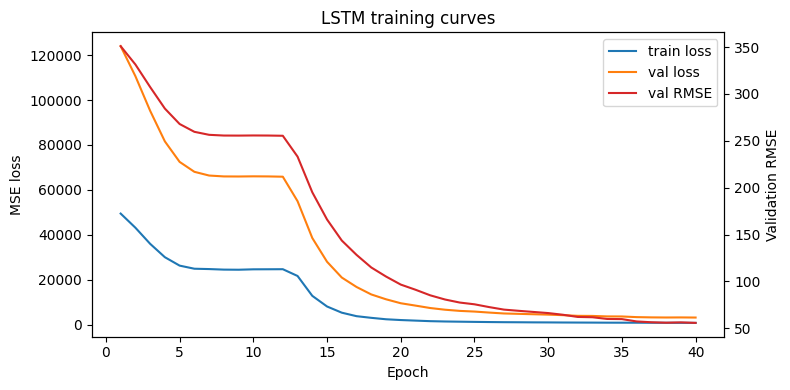

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history["epoch"], history["train_loss"], label="train loss")
ax.plot(history["epoch"], history["val_loss"], label="val loss")
ax2 = ax.twinx()
ax2.plot(history["epoch"], history["val_rmse"], color="tab:red", label="val RMSE")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
ax2.set_ylabel("Validation RMSE")
ax.set_title("LSTM training curves")
(lines1, labels1) = ax.get_legend_handles_labels()
(lines2, labels2) = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

save_plot(fig, "lstm_train_curves.png")

## Validation RMSE Table

In [7]:
val_table = history[["epoch", "val_rmse", "val_mae"]].tail(10).reset_index(drop=True)
val_table.style.format({"val_rmse": "{:.2f}", "val_mae": "{:.2f}"})

,epoch,val_rmse,val_mae
0,31,64.40,38.83
1,32,62.08,37.46
2,33,61.76,37.47
3,34,59.92,36.62
4,35,59.77,36.94
5,36,57.26,35.17
6,37,56.40,35.23
7,38,55.92,35.18
8,39,56.27,34.85
9,40,55.73,35.16


## Evaluation Metrics

In [8]:
metrics_path = Path(lstm_run["metrics_path"])
metrics_payload = json.loads(metrics_path.read_text())
print(f"Device used: {metrics_payload['device']}")

eval_df = pd.DataFrame(
    [metrics_payload["best_val"], metrics_payload["test"]],
    index=["validation", "test"],
)

eval_df

Device used: cpu


,rmse,mae
validation,55.729916,35.159985
test,49.617918,31.067560


## Resource Requirements
- Default configuration runs comfortably on CPU (~4â€“5 minutes for 40 epochs on a modern laptop) using the PyTorch CPU wheels installed above.
- Set `use_gpu=True` in `run_experiment` if a CUDA-capable device is available; training time then drops to seconds, but ensure matching CUDA wheels are installed.
- Memory footprint stays under ~2â€¯GB thanks to batching (`batch_size=256`, `seq_len=48`); monitor VRAM if enabling GPU acceleration.